In [3]:
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
import pickle  # To save and load dictionaries
from itertools import combinations
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from NNetwork import NNetwork as nn
from src.sampling.Sampling import sampling_sndl
from src.supervised_NDL.SNDL import sndl_equalEdge, sndl_predict
from util.plotting import *
from contextlib import contextmanager

In [4]:
@contextmanager
def suppress_output():
    """Context manager to suppress stdout."""
    with open(os.devnull, 'w') as fnull:
        original_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = original_stdout

In [39]:
def get_save_path(ntwk_list, base_sample_size, k, xi, n_components, iterations, baseline_i):
    """Generate a unique file path for saving the dictionary based on parameters."""
    params_str = f"bs{base_sample_size}_k{k}_xi{xi}_nc{n_components}_iter{iterations}_bi{baseline_i}"
    ntwk_str = "_".join(ntwk_list[baseline_i:baseline_i+3])
    filename = f"dictionaries/{ntwk_str}_{params_str}.pkl"
    print("Getting save path...")
    return filename

def save_dictionary(W, beta, H, filepath):
    """Save W, beta, H to a file."""
    with open(filepath, 'wb') as f:
        pickle.dump((W, beta, H), f)
        print("Saving dictionary...")

def load_dictionary(filepath):
    """Load W, beta, H from a file."""
    with open(filepath, 'rb') as f:
        W, beta, H = pickle.load(f)
        print("Loading dictionary...")
    return W, beta, H

def compute_latent_motifs_and_dictionary(ntwk_list, base_sample_size, k, xi, n_components, iterations, baseline_i=0):
    """Compute or load the latent motifs and dictionary for a given baseline."""
    filepath = get_save_path(ntwk_list, base_sample_size, k, xi, n_components, iterations, baseline_i)
    
    if os.path.exists(filepath):
        print(f"Loading precomputed dictionary from {filepath}")
        W, beta, H = load_dictionary(filepath)
    else:
        print(f"Computing dictionary for baseline {baseline_i} and saving to {filepath}")
        graph_list = []
        for ntwk in ntwk_list[baseline_i:baseline_i+3]:
            path = f"data/{ntwk}.txt"
            G = nn.NNetwork()
            G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
            graph_list.append(G)
        
        with suppress_output():
            W, beta, H = sndl_equalEdge(graph_list, base_sample_size=base_sample_size, k=k, xi=xi, n_components=n_components, iter=iterations)
            print("Calling `sndl_equalEdge` and computing dictionary")
        save_dictionary(W, beta, H, filepath)
    
    return W, beta, H

def compute_prediction_scores(G, W, beta, sample_size):
    """Compute prediction scores for a given graph and dictionary."""
    with suppress_output():
        prob = sndl_predict(G, W, beta, sample_size)
        print("Computing prediction scores...")
    return prob

def compute_affinity_scores_for_all_networks(ntwk_list, W, beta, baseline_i):
    """Compute affinity scores for the networks."""
    affinity_scores = {}
    for ntwk in ntwk_list:
        path = "data/" + str(ntwk) + '.txt'
        G = nn.NNetwork()
        G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
        prob = compute_prediction_scores(G, W, beta, 500)
        affinity_scores[ntwk] = prob
    return affinity_scores

def triangle_area(p1, p2, p3):
    """Calculate the area of a triangle given its vertices."""
    p1, p2, p3 = np.array(p1, dtype=float), np.array(p2, dtype=float), np.array(p3, dtype=float)
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

def plot_3d_affinity_scores(ntwk_list, affinity_scores, baseline_i, view_angle=(30, 60)):
    """Plot 3D affinity scores for the networks on a single graph."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    print("Plotting...")

    colors = plt.cm.get_cmap('tab10', len(ntwk_list))
    markers = ['v', 's', 'p', '^', 'D', '*', 'P', 'X', 'h']

    # Plot Standards with same color as first three networks
    standard_points = []
    for idx in range(3):
        point = [idx == 0, idx == 1, idx == 2]
        standard_points.append(point)
        ax.scatter(point[0], point[1], point[2], color=colors(baseline_i + idx), s=50)

    # Plot prediction scores for all networks    
    all_points = []
    labels = []
    coordinates = []
    for idx, (ntwk, prob) in enumerate(affinity_scores.items()):

        point = np.array([prob[0], prob[1], prob[2]])
        all_points.append(point)
        labels.append(ntwk)
        coordinates.append(f'({prob[0]:.2f}, {prob[1]:.2f}, {prob[2]:.2f})')

        if idx in [baseline_i, baseline_i+1, baseline_i+2]:
            ax.scatter(point[0], point[1], point[2], color=colors(idx), s=50, label=f'{ntwk}', marker='o')
        else:
            marker_idx = (idx + 3) % len(markers)  # Use a different marker shape for non-baseline points
            ax.scatter(point[0], point[1], point[2], color=colors(idx), s=50, marker=markers[marker_idx], label=f'{ntwk}')

    tri_vertices = np.array(standard_points)
    tri = Poly3DCollection([tri_vertices], alpha=0.3, color='grey')
    ax.add_collection3d(tri)

    small_tri_vertices = np.array(all_points[baseline_i:baseline_i+3])
    small_tri = Poly3DCollection([small_tri_vertices], alpha=0.3, edgecolor='r', color='yellow')
    ax.add_collection3d(small_tri)

    big_triangle_area = triangle_area(*tri_vertices)
    small_triangle_area = triangle_area(*small_tri_vertices[:3])
    area_ratio = small_triangle_area / big_triangle_area

    ax.text2D(0.05, 0.95, f'Area Ratio = {small_triangle_area:.2f} / {big_triangle_area:.2f} = {area_ratio:.2f}', transform=ax.transAxes)
    
    ax.set_xlabel(ntwk_list[baseline_i])
    ax.set_ylabel(ntwk_list[baseline_i+1])
    ax.set_zlabel(ntwk_list[baseline_i+2])
    ax.set_title('3D Visualization of Predicted Network Similarities')

    # Set the legend at the bottom
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)

    ax.view_init(elev=view_angle[0], azim=view_angle[1])

    # Add a table to display the coordinates, positioned below the plot
    print("Adding a table...")
    table_data = list(zip(labels, coordinates))
    col_labels = ["Network", "Coordinates"]
    ax_table = plt.axes([0.1, 0.01, 0.8, 0.15])  # Positioning the table below the plot
    ax_table.axis("off")
    table = ax_table.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.scale(1, 1.5)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.3)  # Adjust plot to fit table nicely


    return fig  # Return the figure to combine them later

def plot_3d_prediction(ntwk_list, base_sample_size, k, n_components, iterations, baseline_i):
    """Compute and plot 3D prediction of network similarities."""
    n = len(ntwk_list)
    if n <= 3:
        print("Not enough networks for comparison.")
        return

    # Create a directory to store dictionaries if it doesn't exist
    os.makedirs('dictionaries', exist_ok=True)
    
    # Compute dictionary for the baseline set of 3 networks
    W, beta, H = compute_latent_motifs_and_dictionary(ntwk_list, base_sample_size=base_sample_size, k=k, xi=7, n_components=n_components, iterations=iterations, baseline_i=baseline_i)

    # Compute affinity scores for all networks
    affinity_scores = compute_affinity_scores_for_all_networks(ntwk_list, W, beta, baseline_i)

    # Generate and show a single plot with all networks, including the baseline and additional ones
    fig = plot_3d_affinity_scores(ntwk_list, affinity_scores, baseline_i)
    plt.show()

Getting save path...
Loading precomputed dictionary from dictionaries/Caltech36_UCLA26_MIT8_bs500_k50_xi7_nc25_iter250_bi0.pkl
Loading dictionary...
Plotting...
Adding a table...


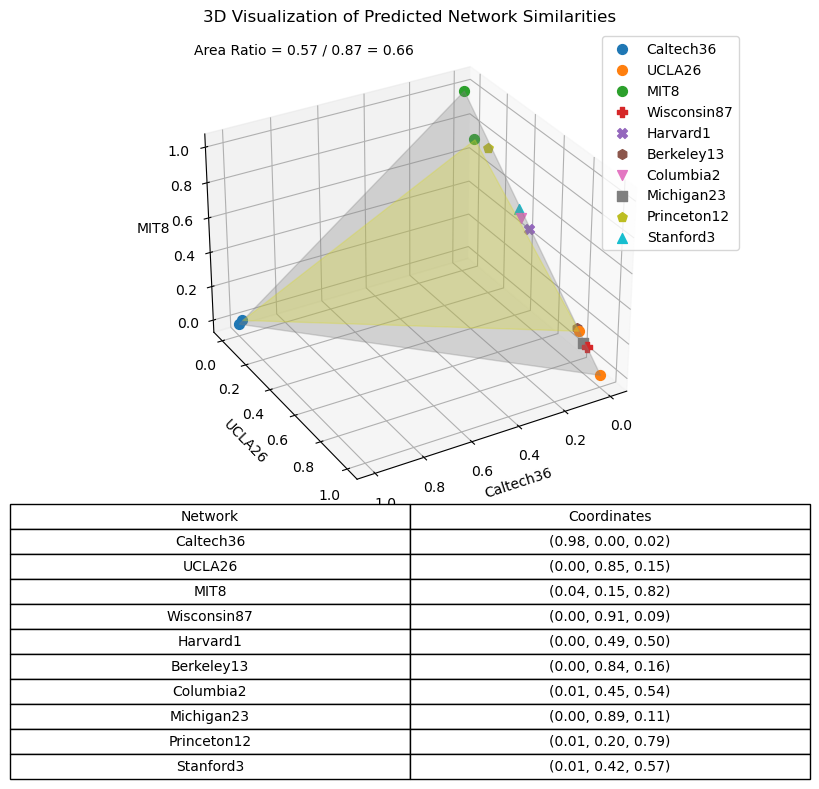

In [44]:
# Example usage
ntwk_list = ['Caltech36', 'UCLA26', 'MIT8', 'Wisconsin87', 'Harvard1', 'Berkeley13', 'Columbia2', 'Michigan23', 'Princeton12', 'Stanford3']
plot_3d_prediction(ntwk_list, base_sample_size=500, k=50, n_components=25, iterations=250, baseline_i=0)

In [ ]:
# Example usage
ntwk_list = ['UCLA26', 'MIT8', 'Harvard1', 'Wisconsin87', 'Berkeley13', 'Columbia2', 'Michigan23', 'Princeton12', 'Stanford3', 'Caltech36']
plot_3d_prediction(ntwk_list, base_sample_size=500, k=50, n_components=25, iterations=250, baseline_i=0)

In [7]:
# Example usage
ntwk_list = ['bio-human', 'bio-fruitfly', 'bio-plant', 'bio-worm', 'bio-mouse']
plot_3d_prediction(ntwk_list, base_sample_size=300, k=25, n_components=16, iterations=150, baseline_i=0)

Computing dictionary for baseline 0 and saving to dictionaries/bio-human_bio-fruitfly_bio-plant_bs300_k25_xi7_nc16_iter150_bi0.pkl
